In [211]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Subset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split

import torchvision
import torchvision.transforms as T

import sys
import copy


import matplotlib.pyplot as plt


In [212]:
# train_set = torchvision.datasets.EMNIST(
#     root='./data/emnist', split='letters', train=True, download=True)

# val_dataset = torchvision.datasets.EMNIST(
#     root='./data/emnist', split='letters', train=False, download=True)

# train_img = train_set.data.view([train_set.data.shape[0],1,28,28]).float()
# val_img = train_set.data.view([train_set.data.shape[0],1,28,28]).float()


# val_dataset.data.shape
# images = val_dataset.data.view([20800,1,28,28]).float()
# labels = val_dataset.


In [213]:
train_set = torchvision.datasets.EMNIST(
    root='./data/emnist', split='letters', transform=T.Compose([T.ToTensor()]), train=True, download=True)

train_set.classes = train_set.classes[1:]
train_set.targets = train_set.targets - 1

mean = (train_set.data.float().mean()/255).item()
std = (train_set.data.float().std()/255).item()
print("mean", mean)
print("std", std)

img_size = 28

transforms = T.Compose([
    T.ToTensor(),
    # T.Resize((28, 28), antialias=True),
    # T.RandomHorizontalFlip(),
    # T.RandomVerticalFlip(),
    # T.RandomAutocontrast(),
    # T.RandomRotation(30),
    T.Normalize(mean, std)
])

train_set.transform = transforms

val_dataset = torchvision.datasets.EMNIST(
    root='./data/emnist', split='letters', transform=transforms, train=False, download=True)

val_dataset.classes = val_dataset.classes[1:]
val_dataset.targets = val_dataset.targets - 1

print("train_classes", len(train_set.classes))

print("val_classes", (len(val_dataset.classes)))

print("train_classes", len(train_set.classes))

print("train_targets", torch.unique(train_set.targets))


print("val_targets", torch.unique(val_dataset.targets))
val_set, test_set = random_split(val_dataset, [.5, .5])


mean 0.17222730815410614
std 0.3309466242790222
train_classes 26
val_classes 26
train_classes 26
train_targets tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])
val_targets tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])


In [214]:
print('Data shapes:')
print(f"Image Shape: {train_set.data[0].shape}")
print(f"Classes: {len(train_set.classes)}")

print(f"Train Set: {len(train_set)}")
print(f"Val Set: {len(val_set)}")
print(f"Test Set: {len(val_set)}")

# Categories
print(f'\nData categories:\n{train_set.classes}')


Data shapes:
Image Shape: torch.Size([28, 28])
Classes: 26
Train Set: 124800
Val Set: 10400
Test Set: 10400

Data categories:
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [215]:
batch_size = 64
train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_set))
test_loader = DataLoader(test_set, batch_size=len(test_set))


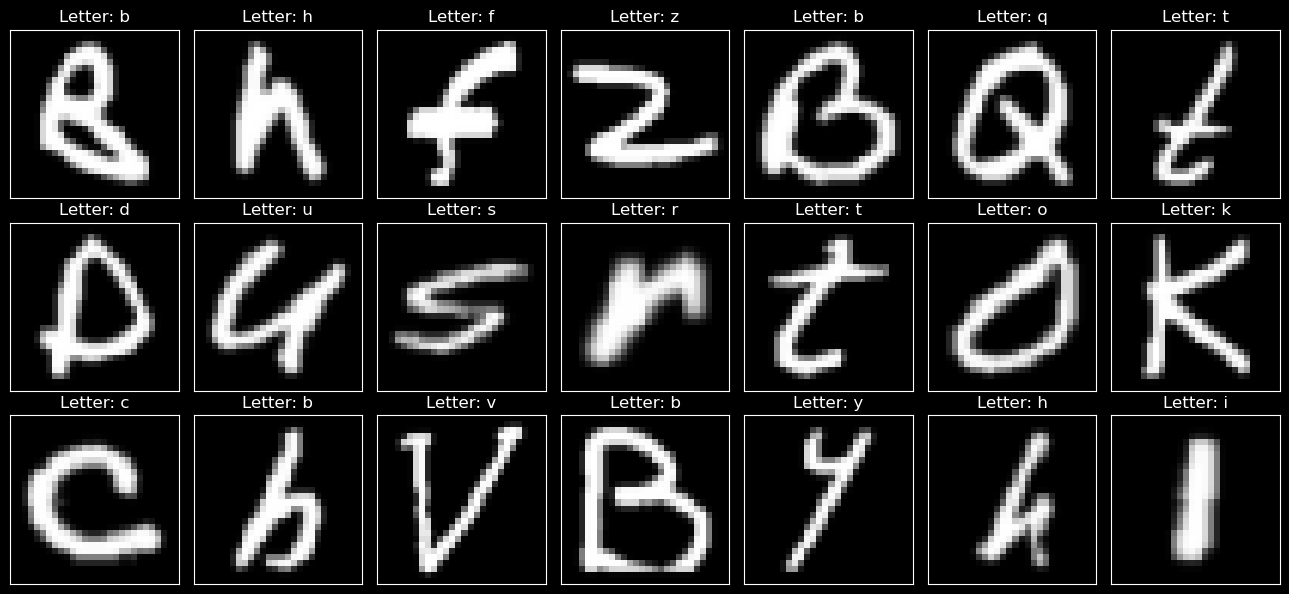

In [216]:
# Visualize data
fig, axs = plt.subplots(3, 7, figsize=(13, 6))

for (i, ax) in enumerate(axs.flatten()):

    # extract that image
    pic_i = np.random.randint(val_dataset.data.shape[0])
    pic = val_dataset.data[pic_i, :, :].numpy().transpose(1, 0)

    # and its label
    label = val_dataset.classes[val_dataset.targets[pic_i]]

    # and show!
    ax.imshow(pic, cmap='gray')
    ax.set_title(f"Letter: {label}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [217]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [218]:


# def make_net(c_l=[32, 64, 128], kernel_size=(4,4), stride=(1,1), padding=1):
#     def get_img_size(w, h, p):
#        img_size_w = np.floor((w+2*p[1] - kernel_size[1])/stride[1]) + 1
#        img_size_w = np.floor(img_size_w/2)

#        img_size_h = np.floor((h+2*p[0] - kernel_size[0])/stride[0]) + 1
#        img_size_h = np.floor(img_size_h/2)

#        return int(img_size_w), int(img_size_h)

#     class Net(nn.Module):
#         def __init__(self):
#             super().__init__()
#             self.layers = nn.ModuleDict()
#             self.image_size = 28
#             self.in_channels = 1

#             c_l.insert(0, 28)


#             self.layers[f"conv0"] = nn.Conv2d(1, c_l[0], kernel_size, stride, padding)
#             self.size = get_img_size(28,28, self.layers[f"conv0"].padding)

#             self.layers[f"bnorm0"] = nn.BatchNorm2d(c_l[0])

#             for i, conv in enumerate(c_l, 1):
#                 print("klk",  self.size)
#                 self.layers[f"conv{i}"] = nn.Conv2d(
#                     c_l[i-1], conv, kernel_size, padding)
#                 self.layers[f"bnorm{i}"] = nn.BatchNorm2d(conv)

#                 self.size = get_img_size(self.size[0],self.size[1], self.layers[f"conv{i}"].padding)

#             self.fc1 = nn.Linear(np.prod(self.size)*c_l[-1],26)


#         def forward(self, x):
#             for i in range(len(c_l)):
#                 x = F.max_pool2d(self.layers[f"conv{i}"](x), 2)
#                 x = F.relu(self.layers[f"bnorm{i}"](x))

#             nUnits = x.shape.numel()/x.shape[0]
#             x = x.view(-1,int(nUnits))

#             x = F.relu(self.fc1(x))
#             return x
#     net = Net()
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(net.parameters(), lr=.001)

#     return net, criterion, optimizer

# test_net, criterion, optimizer = make_net()

# summary(test_net.cuda(), (1,28,28))


In [219]:
def create_model():
    kernel_size, padding = 4, 1
    conv1 = 256
    conv2 = conv1*2
    conv3 = conv2*2
    conv4 = conv3*2

    img_size = 28
    for conv_i in range(1, 4):
        img_size = int((img_size+2*padding-kernel_size + 1)/2)

    # (28+2*1-kernel_size + 1)/2

    net = nn.Sequential(
        nn.Conv2d(1, conv1, kernel_size, padding=padding),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(conv1),
        nn.ReLU(),
        nn.Dropout(.25),


        nn.Conv2d(conv1, conv2, kernel_size, padding=padding),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(conv2),
        nn.ReLU(),
        nn.Dropout(.25),


        nn.Conv2d(conv2, conv3, kernel_size, padding=padding),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(conv3),
        nn.ReLU(),
        nn.Dropout(.25),

        # nn.Conv2d(conv3, conv4, kernel_size, padding=padding),
        # nn.MaxPool2d(2),
        # nn.BatchNorm2d(conv4),
        # nn.ReLU(),
        # nn.Dropout(.25),

        # nn.Conv2d(128, 256, kernel_size=4, padding=2),
        # nn.BatchNorm2d(256),
        # nn.ReLU(),
        # # nn.Dropout(.2),
        # nn.MaxPool2d(2),


        nn.Flatten(),
        nn.Linear(img_size**2*conv3, 1024),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(1024, 26),
        # nn.ReLU(),
        # nn.Dropout(),
        # nn.Linear(1024, 26),

        # nn.BatchNorm1d(512),
        # nn.ReLU(),
        # nn.Dropout(p=0.5),
        # nn.Linear(256, 26),

        # nn.Dropout(),
        # nn.Linear(256, 26),

        # nn.Linear(512, 26),
        # nn.Linear(256, 26),

    )
    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=1e-5)
 weight_decay=1e-5
    optimizer = torch.optim.SGD(
        net.parameters(), lr=.001, weight_decay=1e-5, momentum=.9)

    return net, criterion, optimizer


test_net, criterion, optimizer = create_model()


In [220]:
test_net, criterion, optimizer = create_model()
# Test that the model works
X, y = next(iter(train_loader))
yHat = test_net(X)

# summary(test_net, (1, 28, 28), device="cpu")


In [221]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = "cpu"


def train_model(epochs=25):

    model, criterion, optimizer = create_model()
    model.to(device)

    step_size = 64*len(train_loader.dataset)
    def lambda1(epoch): return 0.65 ** epoch

    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=.5)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1,20], gamma=.1)

    # call this meta
    meta = {"epoch": 0, "loss": np.inf, "val_acc": 0, "state": None}

    train_loss, val_loss = torch.zeros(epochs), torch.zeros(epochs)
    train_acc, val_acc = torch.zeros(epochs), torch.zeros(epochs)

    for epoch in range(epochs):
        model.train()
        batch_loss, batch_acc = [], []
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            y_hat = model(X)
            loss = criterion(y_hat, y)

            # Back propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # scheduler.step()

            batch_loss.append(loss.item())
            batch_acc.append(torch.mean(
                (torch.argmax(y_hat, axis=1) == y).float()).item())

        train_loss[epoch] = np.mean(batch_loss)
        train_acc[epoch] = np.mean(batch_acc)

        model.eval()
        X, y = next(iter(val_loader))
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y_hat = model(X)
            loss = criterion(y_hat, y)

        val_loss[epoch] = loss.item()
        val_acc[epoch] = torch.mean(
            (torch.argmax(y_hat, axis=1) == y).float()).item()

        if(meta["loss"] > val_loss[epoch]):
            meta = {"loss": val_loss[epoch], "epoch": epoch, "val_acc": val_acc[epoch],
                    "state": copy.deepcopy(model.state_dict())}
        # Print logs
        print(f"Epoch {(epoch+1)}/{epochs}",
              f"- loss: {train_loss[epoch]:.4f}",
              f"- acc: {train_acc[epoch]:.4f}",
              f"- val_loss: {val_loss[epoch]:.4f}",
              f"- val_acc: {val_acc[epoch]:.4f}"
              f" - Best: acc: {meta['val_acc']:.4f}"
              )

    model.load_state_dict(meta["state"])
    return model, train_loss, val_loss, train_acc, val_acc, meta


In [222]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


In [223]:
# torch.manual_seed(4568041434530468791)
net, train_loss, val_loss, train_acc, val_acc, meta = train_model(100)

# switch to test mode
# net.cpu ()
# net.eval()

# print("Done")
# 18 -> 0.9469
# Best 0.9531

# 14 -> 95 -> 0.9539

# epoch: 21 val_acc: 0.9546 fc1 -> 128
# Epoch 16 val_acc: 0.9541 with `32`
# Epoch 16 val_acc: 0.9554 `784`
# 0.9550 `784`


Epoch 1/100 - loss: 0.3535 - acc: 0.8881 - val_loss: 0.2689 - val_acc: 0.9066 - Best: acc: 0.9066
Epoch 2/100 - loss: 0.2333 - acc: 0.9247 - val_loss: 0.2024 - val_acc: 0.9306 - Best: acc: 0.9306
Epoch 3/100 - loss: 0.2072 - acc: 0.9322 - val_loss: 0.2129 - val_acc: 0.9255 - Best: acc: 0.9306
Epoch 4/100 - loss: 0.1871 - acc: 0.9382 - val_loss: 0.2012 - val_acc: 0.9277 - Best: acc: 0.9277
Epoch 5/100 - loss: 0.1742 - acc: 0.9401 - val_loss: 0.2026 - val_acc: 0.9292 - Best: acc: 0.9277
Epoch 6/100 - loss: 0.1642 - acc: 0.9434 - val_loss: 0.2098 - val_acc: 0.9262 - Best: acc: 0.9277
Epoch 7/100 - loss: 0.1564 - acc: 0.9459 - val_loss: 0.2153 - val_acc: 0.9220 - Best: acc: 0.9277
Epoch 8/100 - loss: 0.1499 - acc: 0.9477 - val_loss: 0.2059 - val_acc: 0.9238 - Best: acc: 0.9277
Epoch 9/100 - loss: 0.1440 - acc: 0.9491 - val_loss: 0.2023 - val_acc: 0.9267 - Best: acc: 0.9277
Epoch 10/100 - loss: 0.1389 - acc: 0.9505 - val_loss: 0.2165 - val_acc: 0.9264 - Best: acc: 0.9277
Epoch 11/100 - loss

KeyboardInterrupt: 

In [ ]:
net.eval()
X, y = next(iter(test_loader))
X, y = X.to(device), y.to(device)
with torch.no_grad():
    y_hat = net(X)
    loss_fun = criterion(y_hat, y)

test_loss = loss_fun.item()
test_acc = torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item()

print(test_acc)


0.9504807591438293


In [ ]:
X, y = next(iter(test_loader))
X, y = X.to(device), y.to(device)
y_hat = net(X)

error_indices = np.where(torch.argmax(y_hat.cpu(), axis=1) != y.cpu())[0]
errors_n = len(error_indices)

print(f"Mismatches: {errors_n}")
# 560
# 547


Mismatches: 515


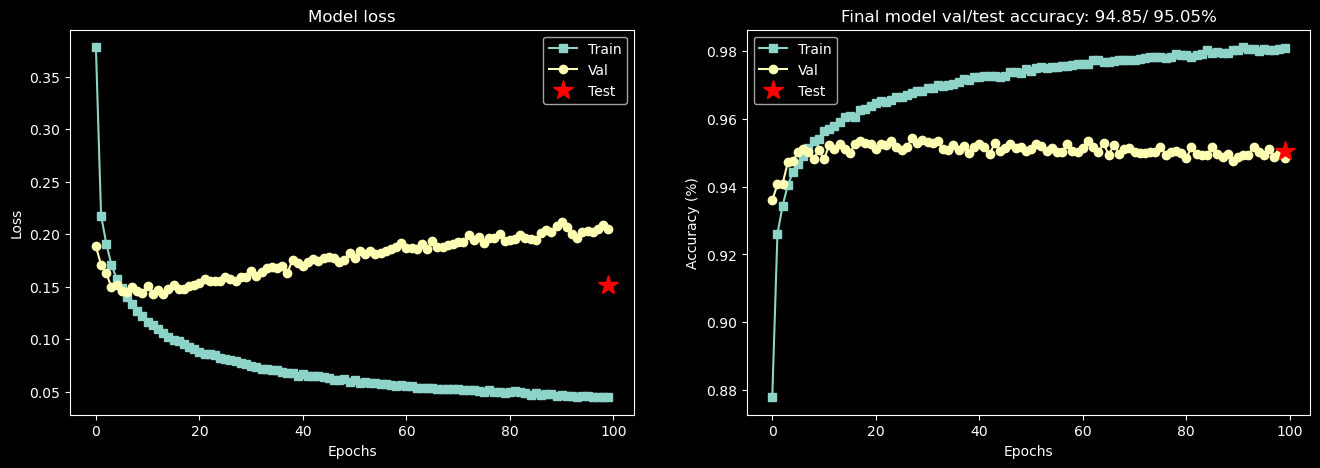

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(train_loss, 's-', label="Train")
ax[0].plot(val_loss, 'o-', label="Val")
ax[0].plot(len(val_loss)-1, test_loss, 'r*', markersize=15, label='Test')

ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(train_acc, 's-', label='Train')
ax[1].plot(val_acc, 'o-', label='Val')
ax[1].plot(len(val_acc)-1, test_acc, 'r*', markersize=15, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(
    f'Final model val/test accuracy: {val_acc[-1]*100:.2f}/ {test_acc*100:.2f}%')
ax[1].legend()

plt.show()
